In [64]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from dict_net import *
from deep_dream import *
import torchvision

In [65]:
net = DictNet2(772)

In [66]:
net

DictNet2(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2)

In [67]:
net.load_state_dict(torch.load("../models/net_772_0.001_64_0.0.pth"))

<All keys matched successfully>

In [68]:
dreamer = DeepDream(net,(1,32,128),(0.47,),(0.14,),use_gaussian_filter=True)

Device used to run this program:  cuda
Loading the network...
Network Loaded
Gaussian filter will be used


In [69]:
labels = [0,1,2,3]
labels_tensor = torch.LongTensor(labels)

In [70]:
random_seed = 0

In [71]:
im = dreamer.createInputImage(random_seed)
im = dreamer.prepInputImage(im)
im.shape

torch.Size([1, 32, 128])

In [72]:
im = torch.stack([im]*4,dim=0)
im = im.to(dreamer.device)
im = Variable(im,requires_grad=True)

In [73]:
im.shape

torch.Size([4, 1, 32, 128])

In [74]:
for _ in range(400):
    out = dreamer.net(im)
    
    loss = 0
    for i in range((out.shape)[0]):
        loss += out[i,labels[i]]
    
    loss.backward()
    
    avg_grad = np.abs(im.grad.data.cpu().numpy()).mean()
    norm_lr = 0.1 / (avg_grad + 1e-20)
    im.data += norm_lr*im.grad.data
    im.data = torch.clamp(im.data,-1,1)
    
    im.data = dreamer.gaussian_filter(im.data)
    im.grad.data.zero_()

In [75]:
im.shape

torch.Size([4, 1, 32, 128])

In [76]:
img_tensor = im.data*0.14 + 0.47
img_tensor = img_tensor.cpu()

In [77]:
grid_img = torchvision.utils.make_grid(img_tensor)

In [78]:
grid_img.shape

torch.Size([3, 36, 522])

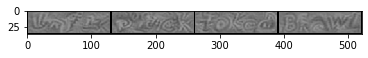

In [79]:
plt.imshow(grid_img.permute(1, 2, 0))